In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.io as io

In [2]:
class ReconstructedField:

    def __init__(self, global_step, adv_diff_params={}, sources=None, peak_conc=None):
        # Adv-diff param defaults
        self.dx = adv_diff_params.get("dx", 0.8)
        self.dy = adv_diff_params.get("dy", 0.8)
        self.vx = adv_diff_params.get("vx", -0.6)
        self.vy = adv_diff_params.get("vy", 0.8)
        self.dt = adv_diff_params.get("dt", 0.1)
        self.k = adv_diff_params.get("k", 1.0)

        # Field params
        self.field_size = [100, 100]
        self.global_step = global_step
        self.local_step = 0

        # Agent's recreated field
        self.agent_reconstructed_field = np.zeros(self.field_size)

        # Load mat file for gaussian
        self.source_template = self.load_source()
        self.template_peak_conc = np.max(self.source_template)

        # Create field based on sources
        if sources is not None:
            assert peak_conc is not None, "Provide peak concentration for each of the sources"
            assert len(peak_conc) == len(
                sources), "Provide peak concentration for each of the sources"

            for src, conc in zip(sources, peak_conc):
                print("Adding source at " + str(src) +
                      " with conc " + str(conc))
                self.add_source(src, conc)

    def load_source(self):
        cwd = os.getcwd()
        loaded_mat = io.loadmat(cwd + "/u.mat")
        u = loaded_mat.get('u')

        # Find center of source template
        max_loc = np.unravel_index(np.argmax(u), u.shape)

        # Move the center to [50, 50]
        centered = u.copy()
        row_shift = 50 - max_loc[0]
        col_shift = 50 - max_loc[1]

        for r in range(0, self.field_size[0]):
            for c in range(0, self.field_size[1]):
                centered[r, c] = u[(r - row_shift) % self.field_size[0],
                                   (c - col_shift) % self.field_size[1]]
        return centered

    def add_source(self, source_location, concentration):
        # Make a copy of the template
        new_source = self.source_template.copy()

        # Find the factor to reduce concentration by and scale the array
        conc_reduction_factor = concentration / self.template_peak_conc
        new_source *= conc_reduction_factor

        # Move source to desired location
        new_source_copy = new_source.copy()
        row_shift = source_location[0] - 50
        col_shift = source_location[1] - 50

        for r in range(0, self.field_size[0]):
            for c in range(0, self.field_size[1]):
                new_source[r, c] = new_source_copy[(r - row_shift) % self.field_size[0],
                                                   (c - col_shift) % self.field_size[1]]

        # Add the new source to existing field
        self.agent_reconstructed_field += new_source

    def update_reconstructed_field(self):
        updated_u = self.agent_reconstructed_field.copy()
        u_k = self.agent_reconstructed_field.copy()

        dx = self.dx
        dy = self.dy
        dt = self.dt
        vx = self.vx
        vy = self.vy
        k = self.k

        # fmt: off
        for i in range(1, self.field_size[0] - 1):
            for j in range(1, self.field_size[1] - 1):
                updated_u[j, i] = u_k[j, i] + k * (dt / dx ** 2) * \
                    ((u_k[j + 1, i] + u_k[j - 1, i] +
                      u_k[j, i + 1] + u_k[j, i - 1] - 4 * u_k[j, i])) + \
                    vx * (dt / dx) * ((u_k[j + 1, i] - u_k[j, i])) + vy * (dt / dy) * \
                    (u_k[j, i + 1] - u_k[j, i])
        # fmt: on                                                                                                                                                                                          i])
        self.agent_reconstructed_field = updated_u
        self.global_step += 1
        self.local_step += 1

    def calculate_mapping_error(self, env_field):
        return np.sum(np.abs(self.agent_reconstructed_field - env_field))

    def test_view_source_template(self):
        plt.imshow(self.source_template.T, cmap="Blues")
        plt.show()

    def test_view_agent_reconstructed_field(self):
        print("Max value: " + str(np.max(self.agent_reconstructed_field)))
        print("Max value at: " +
              str(np.unravel_index(np.argmax(self.agent_reconstructed_field),
                                   self.agent_reconstructed_field.shape)))

        fig = plt.figure()
        plt.imshow(self.agent_reconstructed_field.T, cmap="Blues")

        title_str = "Global Step: " + \
            str(self.global_step) + ", Local step: " + str(self.local_step) + \
            ". Params (vx, vy): " + str((self.vx, self.vy))
        plt.title(title_str)
        plt.show()

Adding source at [20, 30] with conc 18
Adding source at [60, 65] with conc 18
Max value: 17.78643386940832
Max value at: (65, 63)


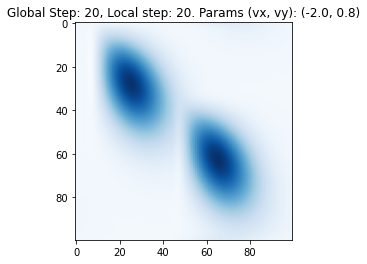

Max value: 24.070470105717202
Max value at: (98, 53)


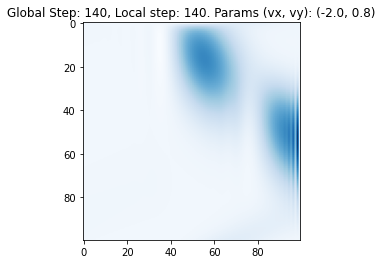

Max value: 20.121788782892768
Max value at: (98, 7)


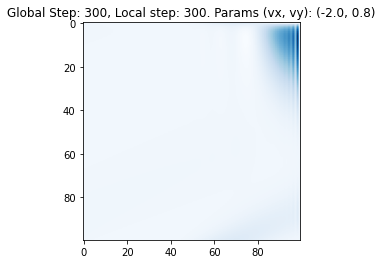

In [3]:
sources = [[20, 30], [60, 65]]
peak_concs = [18, 18]
adv_diff_params = {"vx": -2.0}
recon_field = ReconstructedField(0, sources=sources, peak_conc=peak_concs, adv_diff_params=adv_diff_params)

for i in range(20):
    recon_field.update_reconstructed_field()
recon_field.test_view_agent_reconstructed_field()

for i in range(120):
    recon_field.update_reconstructed_field()
recon_field.test_view_agent_reconstructed_field()

for i in range(160):
    recon_field.update_reconstructed_field()
recon_field.test_view_agent_reconstructed_field()